In [1]:
import sys
paths_to_add = ["/homes/vk223/ProjectFlood", "/home/vkhandekar/project_flood"]
for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)
print(sys.path)
from evaluation.model_evaluation_helpers import *
from model_runs.model_run_helpers import *
from model_runs.distributed_gpu_helpers import *
from visualisations.visualisation_helpers import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
print(os.getcwd())

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/vkhandekar/project_flood/.venv/lib/python3.10/site-packages', '/homes/vk223/ProjectFlood', '/home/vkhandekar/project_flood']
/home/vkhandekar/project_flood/evaluation


In [2]:
# os.environ["PROJECT_FLOOD_DATA"] = "/homes/vk223/ProjectFlood/static/imperial_data_paths.json"
# os.environ["PROJECT_FLOOD_CORE_PATHS"] = "/homes/vk223/ProjectFlood/static/imperial_core_paths.json"
os.environ["PROJECT_FLOOD_DATA"] = "/home/vkhandekar/project_flood/static/local_data_paths.json"
os.environ["PROJECT_FLOOD_CORE_PATHS"] = "/home/vkhandekar/project_flood/static/local_core_paths.json"
print(os.environ["PROJECT_FLOOD_DATA"])
resolution = 256
with open(os.environ["PROJECT_FLOOD_DATA"]) as data_config_file:
    data_config = json.load(data_config_file)
with open(os.environ["PROJECT_FLOOD_CORE_PATHS"]) as core_config_file:
    core_config = json.load(core_config_file)

/home/vkhandekar/project_flood/static/local_data_paths.json


In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
torch.manual_seed(42)
# Load newly trained best, final models
# final_sep_branch_model, _, _, final_sep_branch_params = load_checkpoint("/homes/vk223/ProjectFlood/models/saved_models/ConvLSTMMerged_epochs500_batchsize16_lr0p001_precedingrainfall1_dropout0p3_outputchannels8_convblocklayers2_convLSTMlayers2_optimRMSprop_criterionBCELoss_transformsFalse_res256_20240824_500.pt")
# final_merged_model, _, _, final_merged_params = load_checkpoint("/homes/vk223/ProjectFlood/models/saved_models/ConvLSTMSeparateBranches_epochs500_batchsize32_lr0p001_precedingrainfall1_dropout0p5_outputchannels8_convblocklayers2_convLSTMlayers1_optimRMSprop_criterionBCELoss_transformsFalse_res256_20240824_500.pt")
final_sep_branch_model, _, _, final_sep_branch_params = load_checkpoint("/home/vkhandekar/project_flood/models/saved_models/ConvLSTMMerged_epochs500_batchsize16_lr0p001_precedingrainfall1_dropout0p3_outputchannels8_convblocklayers2_convLSTMlayers2_optimRMSprop_criterionBCELoss_transformsFalse_res256_20240824_500.pt")
final_merged_model, _, _, final_merged_params = load_checkpoint("/home/vkhandekar/project_flood/models/saved_models/ConvLSTMSeparateBranches_epochs500_batchsize32_lr0p001_precedingrainfall1_dropout0p5_outputchannels8_convblocklayers2_convLSTMlayers1_optimRMSprop_criterionBCELoss_transformsFalse_res256_20240824_500.pt")

dict_keys(['epochs', 'batchsize', 'lr', 'precedingrainfall', 'dropout', 'outputchannels', 'convblocklayers', 'convLSTMlayers', 'optim', 'criterion', 'transforms', 'res'])
dict_keys(['epochs', 'batchsize', 'lr', 'precedingrainfall', 'dropout', 'outputchannels', 'convblocklayers', 'convLSTMlayers', 'optim', 'criterion', 'transforms', 'res'])


In [4]:
sep_branch_test_dataloader = get_dataloader("test_labels_path", resolution=256, preceding_rainfall_days=final_sep_branch_params['precedingrainfall'], forecast_rainfall_days=1, 
                                                transform=None, batch_size=16, shuffle=False, num_workers=4)
    
merged_test_dataloader = get_dataloader("test_labels_path", resolution=256, preceding_rainfall_days=final_merged_params['precedingrainfall'], forecast_rainfall_days=1, 
                                            transform=None, batch_size=16, shuffle=False, num_workers=4)

In [5]:
dimension_string = core_config[f"rainfall_reprojection_master_{resolution}"]
match = re.search(r'_(\d+)_(\d+)\.tif$', dimension_string)
new_dimension_right, new_dimension_bottom = int(match.group(1)), int(match.group(2))


# model = final_sep_branch_model.to(device)
model = final_sep_branch_model
model.eval()
criterion = getattr(torch.nn, final_sep_branch_params['criterion'])()

# Load the True/False mask; True for permanent water
mask = np.load(os.path.join(data_config["model_results_path"], f"perm_water_mask_{resolution}.npy"))
print(mask.shape)

(256, 203)


In [6]:
# Plot image
with torch.no_grad():
    size = 3
    sep_branch_flooded_images, sep_branch_non_flooded_images = collect_images(final_sep_branch_model, sep_branch_test_dataloader, size)
    merged_flooded_images, merged_non_flooded_images = collect_images(final_merged_model, merged_test_dataloader, size)
    
    with open(os.environ["PROJECT_FLOOD_CORE_PATHS"]) as core_config_file:
        core_config = json.load(core_config_file)
    dimension_string = core_config[f"rainfall_reprojection_master_256"]
    match = re.search(r'_(\d+)_(\d+)\.tif$', dimension_string)
    new_dimension_right, new_dimension_bottom = int(match.group(1)), int(match.group(2))


    selected_sep_branch_outputs = [img[0] for img in sep_branch_flooded_images + sep_branch_non_flooded_images]
    selected_sep_branch_outputs = [i[:new_dimension_bottom, :new_dimension_right] for i in selected_sep_branch_outputs] #crop


    selected_merged_outputs = [img[0] for img in merged_flooded_images + merged_non_flooded_images]
    selected_merged_outputs = [i[:new_dimension_bottom, :new_dimension_right] for i in selected_merged_outputs] #crop

    model_names = ['Branched', 'Merged']
    selected_model_outputs = [selected_sep_branch_outputs, selected_merged_outputs]

    selected_targets = [img[1] for img in sep_branch_flooded_images + sep_branch_non_flooded_images]
    selected_targets = [i[:new_dimension_bottom, :new_dimension_right] for i in selected_targets] #crop


    selected_targets_flooded = [img[2] for img in sep_branch_flooded_images + sep_branch_non_flooded_images] #boolean for flooded or not

    # Do plotting
    # Standard
    with open(os.environ["PROJECT_FLOOD_DATA"]) as data_config_file:
        data_config = json.load(data_config_file)
    plot_filename = os.path.join(data_config["model_results_path"], "final_plots.png")
    plot_final_model_output_vs_label(model_names, selected_model_outputs, selected_targets, selected_targets_flooded, plot_filename, risk=False)

    # Risk
    crs_transform = [0.0226492347869873, 0.0, 88.08430518433968, 0.0, -0.0226492347869873, 26.44864775268901]
    selected_targets_risk = [np.ma.masked_array(i, mask=mask) for i in selected_targets]
    selected_sep_branch_outputs_risk = [np.ma.masked_array(i, mask=mask) for i in selected_sep_branch_outputs]
    selected_merged_outputs_risk = [np.ma.masked_array(i, mask=mask) for i in selected_merged_outputs]
    selected_model_outputs_risk = [selected_sep_branch_outputs_risk, selected_merged_outputs_risk]
    plot_filename = os.path.join(data_config["model_results_path"], "final_plots_risk.png")
    plot_risk_on_map(model_names, selected_model_outputs_risk, selected_targets_risk, selected_targets_flooded, plot_filename, crs_transform)
    # plot_final_model_output_vs_label(model_names, selected_model_outputs_risk, selected_targets, selected_targets_flooded, plot_filename, risk=True)

    # Pixel Differences
    for i in range(len(model_names)):
        plot_filename = os.path.join(data_config["model_results_path"], f"final_plots_{model_names[i]}_pixel_difference.png")
        plot_pixel_difference(model_names[i], selected_model_outputs[i], selected_targets, selected_targets_flooded, plot_filename)


In [7]:
thresholds = np.arange(0, 1.05, 0.05)
confusion_matrices = {thr: np.zeros((2, 2)) for thr in thresholds}
precision_scores = {thr: 0 for thr in thresholds}
recall_scores = {thr: 0 for thr in thresholds}
accuracy_scores = {thr: 0 for thr in thresholds}

total_samples = 0
total_masked_samples = 0

total_loss = 0
total_rmse = 0
total_mae = 0
total_psnr = 0
total_ssim = 0
total_ssim_struct = 0

with torch.no_grad():
    for inputs, labels, _ in sep_branch_test_dataloader: #batch size is first dim. (BXY)
        # inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
        inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)
        outputs = model(inputs)

        # Crop the outputs and labels as required
        cropped_outputs = outputs[..., 0:new_dimension_bottom, 0:new_dimension_right]  
        cropped_labels = labels[..., 0:new_dimension_bottom, 0:new_dimension_right]
        # print(cropped_outputs.shape)

        # Apply mask (retain False values)
        mask_torch = torch.from_numpy(mask)
        mask_torch = mask_torch.unsqueeze(0)
        mask_torch = mask_torch.expand(cropped_outputs.size(0), -1, -1)

        masked_outputs = cropped_outputs[~mask_torch]
        masked_labels = cropped_labels[~mask_torch]

        # 1. Calculate PSNR and SSIM on cropped (but not masked) images
        psnr_value = PSNR(cropped_outputs, cropped_labels)
        ssim_value = SSIM(cropped_outputs, cropped_labels)
        ssim_struct_value = SSIM_structural(cropped_outputs, cropped_labels)
        # print(ssim_value)
        total_psnr += psnr_value.item()
        total_ssim += ssim_value.item()
        total_ssim_struct += ssim_struct_value.item()
        rmse_loss = RMSELoss(cropped_outputs, cropped_labels)
        mae_loss = MAELoss(cropped_outputs, cropped_labels)

        total_rmse += rmse_loss.item()
        total_mae += mae_loss.item()

        # Calculate the total loss
        loss = criterion(cropped_outputs, cropped_labels).item()
        total_loss += loss
        total_samples += cropped_labels.size(0)
        total_masked_samples += masked_labels.size(0)
        # print('cropped label size:', cropped_labels.size(0))
        # print('masked label size:', masked_labels.size())

        # 2. Apply different thresholds and calculate confusion matrices
        for thr in thresholds:
            binary_output = (masked_outputs > thr).float()
            binary_output = binary_output.cpu().numpy().flatten()
            binary_labels = masked_labels.cpu().numpy().flatten()

            cm = confusion_matrix(binary_labels, binary_output, labels=[0, 1])
            confusion_matrices[thr] += cm

            # Calculate accuracy at this threshold
            correct_predictions = (binary_output == binary_labels).sum()
            accuracy_scores[thr] += correct_predictions

/vol/bitbucket/vk223/project_flood/projectfloodvenv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/vol/bitbucket/vk223/project_flood/projectfloodvenv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/vol/bitbucket/vk223/project_flood/projectfloodvenv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/vol/bitbucket/vk223/project_flood/pr

In [8]:
# Calculate averages
avg_rmse = total_rmse / len(sep_branch_test_dataloader)
avg_mae = total_mae / len(sep_branch_test_dataloader)
avg_psnr = total_psnr / len(sep_branch_test_dataloader)
avg_ssim = total_ssim / len(sep_branch_test_dataloader)
avg_ssim_struct = total_ssim_struct / len(sep_branch_test_dataloader)
average_loss = total_loss / len(sep_branch_test_dataloader)
print('psnr:', avg_psnr)
print('ssim:', avg_ssim)
print('average loss:', average_loss)


# Calculate average accuracy for each threshold
for thr in thresholds:
    accuracy_scores[thr] /= total_masked_samples

metric_accumulator = {
    'average_rmse': avg_rmse,
    'average_mae': avg_mae,
    'average_psnr': avg_psnr,
    'average_ssim': avg_ssim,
    'average_ssim_struct': avg_ssim_struct,
    'average_loss': average_loss,
    'confusion_matrices': confusion_matrices, #tn, fp, fn, tp
    'accuracy_scores': accuracy_scores
}

# Calculate the final precision and recall
precision_scores = {}
recall_scores = {}
f1_scores = {}
false_positive_rates = {}
for thr, cm in metric_accumulator['confusion_matrices'].items():
    tn, fp, fn, tp = cm.ravel()  # Unpack the 2x2 confusion matrix
    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    precision_scores[thr] = precision
    recall_scores[thr] = recall
    f1_scores[thr] = (2*precision*recall)/(precision+recall) if (precision + recall) > 0 else np.nan

    false_positive_rates[thr] = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    
metric_accumulator['precision_scores'] = precision_scores
metric_accumulator['recall_scores'] = recall_scores
metric_accumulator['f1_scores'] = f1_scores
metric_accumulator['false_positive_rates'] = false_positive_rates


psnr: 14.696117401123047
ssim: 0.609237864613533
average loss: 0.11454474180936813


In [9]:
metric_accumulator

{'average_rmse': 0.18429196998476982,
 'average_mae': 0.2654130458831787,
 'average_psnr': 14.696117401123047,
 'average_ssim': 0.609237864613533,
 'average_ssim_struct': 0.8477312177419662,
 'average_loss': 0.11454474180936813,
 'confusion_matrices': {np.float64(0.0): array([[      0., 2344219.],
         [      0.,   92365.]]),
  np.float64(0.05): array([[1827273.,  516946.],
         [   6655.,   85710.]]),
  np.float64(0.1): array([[2000947.,  343272.],
         [  12731.,   79634.]]),
  np.float64(0.15000000000000002): array([[2082796.,  261423.],
         [  18350.,   74015.]]),
  np.float64(0.2): array([[2133812.,  210407.],
         [  23150.,   69215.]]),
  np.float64(0.25): array([[2170355.,  173864.],
         [  27443.,   64922.]]),
  np.float64(0.30000000000000004): array([[2197015.,  147204.],
         [  31245.,   61120.]]),
  np.float64(0.35000000000000003): array([[2218028.,  126191.],
         [  34805.,   57560.]]),
  np.float64(0.4): array([[2234898.,  109321.],
   

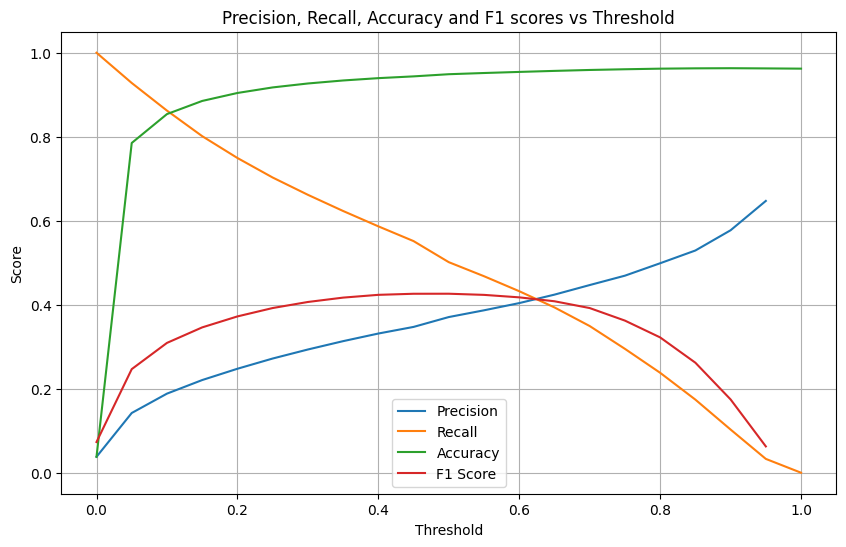

In [10]:
# Extract thresholds, precision, recall, and accuracy from the dictionaries
thresholds = list(metric_accumulator['precision_scores'].keys())
precision_scores = list(metric_accumulator['precision_scores'].values())
recall_scores = list(metric_accumulator['recall_scores'].values())
accuracy_scores = list(metric_accumulator['accuracy_scores'].values())
f1_scores = list(metric_accumulator['f1_scores'].values())

# Create a plot
plt.figure(figsize=(10, 6))

# Plot Precision
plt.plot(thresholds, precision_scores, label='Precision')

# Plot Recall
plt.plot(thresholds, recall_scores, label='Recall')

# Plot Accuracy
plt.plot(thresholds, accuracy_scores, label='Accuracy')

plt.plot(thresholds, f1_scores, label='F1 Score')

# Adding title and labels
plt.title('Precision, Recall, Accuracy and F1 scores vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')

# Adding legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


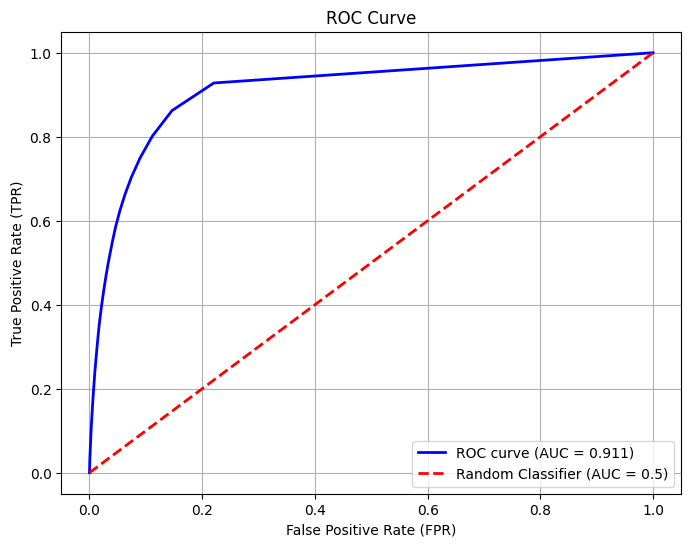

Calculated AUC: 0.91


In [11]:
from sklearn.metrics import auc
fpr = list(metric_accumulator['false_positive_rates'].values())
tpr = list(metric_accumulator['recall_scores'].values())

# Calculate AUC using sklearn's auc function
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')

# Plot the random classifier line (y = x)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')

# Labels and Title
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Display the plot
plt.grid(True)
plt.show()

# Print AUC
print(f'Calculated AUC: {roc_auc:.2f}')

In [12]:
metric_accumulators = [metric_accumulator, metric_accumulator]
model_names = ['Branched', 'Merged']
data = {}
for m in metric_accumulators:
    for key, value in m.items():
        if key not in data:
            data[key] = []
        data[key].append(value)

df = pd.DataFrame(data, index=model_names).T
df


,Branched,Merged
average_rmse,0.184292,0.184292
average_mae,0.265413,0.265413
average_psnr,14.696117,14.696117
average_ssim,0.609238,0.609238
average_ssim_struct,0.847731,0.847731
average_loss,0.114545,0.114545
confusion_matrices,"{0.0: [[0.0, 2344219.0], [0.0, 92365.0]], 0.05...","{0.0: [[0.0, 2344219.0], [0.0, 92365.0]], 0.05..."
accuracy_scores,"{0.0: 0.03790757880705118, 0.05: 0.78510857823...","{0.0: 0.03790757880705118, 0.05: 0.78510857823..."
precision_scores,"{0.0: 0.03790757880705118, 0.05: 0.14222043752...","{0.0: 0.03790757880705118, 0.05: 0.14222043752..."
recall_scores,"{0.0: 1.0, 0.05: 0.9279488983922481, 0.1: 0.86...","{0.0: 1.0, 0.05: 0.9279488983922481, 0.1: 0.86..."


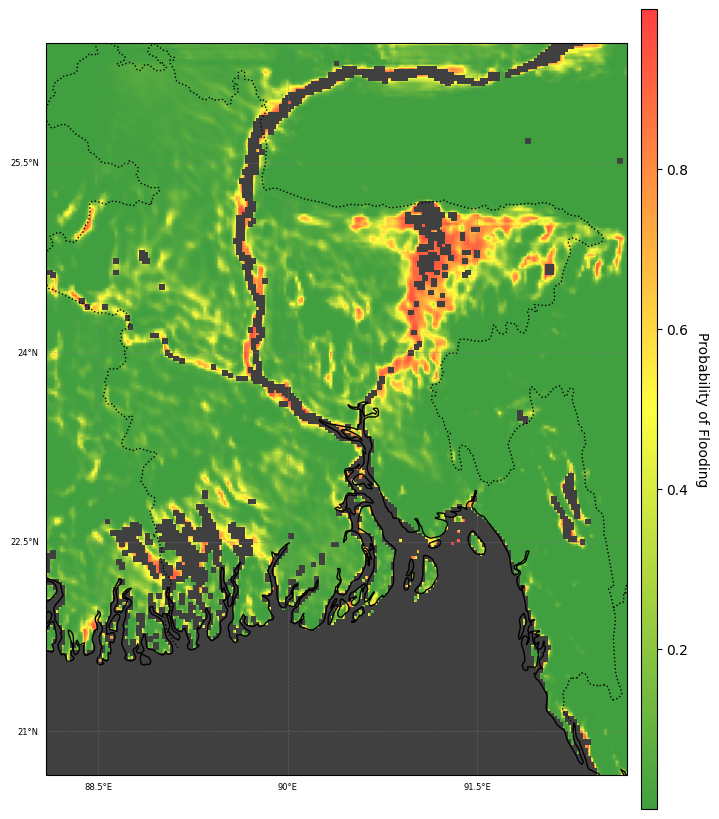

In [35]:


extent = [
    crs_transform[2],  # left (min longitude)
    crs_transform[2] + crs_transform[0] * mask.shape[1],  # right (max longitude)
    crs_transform[5] + crs_transform[4] * mask.shape[0],  # bottom (min latitude)
    crs_transform[5]  # top (max latitude)
]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
risk_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'green'), (0.5, 'yellow'), (1, 'red')])
risk_cmap.set_bad(color='black')
im = ax.imshow(selected_sep_branch_outputs_risk[0], extent=extent, transform=ccrs.PlateCarree(), cmap=risk_cmap, alpha=0.75)
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Disable top labels
gl.right_labels = False  # Disable right labels
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}
gl.xlocator = plt.MaxNLocator(4)  # Reduce number of longitude labels
gl.ylocator = plt.MaxNLocator(5)  # Reduce number of latitude labels
# gl.xformatter = ccrs.Geodetic()._get_longitude_formatter()
# gl.yformatter = ccrs.Geodetic()._get_latitude_formatter()
ax.set_ylabel('Ground Truth', rotation=90, size='large', labelpad=20)



cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=50)
cbar.set_label('Probability of Flooding', rotation=270, labelpad=15)
# plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
# Set the extent to match the image extent (or adjust as necessary)
# ax.set_extent(extent, crs=ccrs.PlateCarree())